<a href="https://www.kaggle.com/code/annkuruvilla/spamclassification-pytorch-transformers?scriptVersionId=127318946" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 

## Spam Text Message Classification 
This implementation  study is using  a smaller sized version of the  "Transformer Encoder's" Architecture  in [Attention is All You Need](https://arxiv.org/abs/1706.03762) , incorporating some of the major components in the same . Currently it is used for a Binary Classification (could also be used for Multi Class) purpose in the below section, for classifying a text message as "spam"(junk)  or "ham" (otherwise/legitimate)  .

## Requirements

In [2]:
%%capture
#Installations
!pip install nltk
!pip install contractions

## Preprocessing

In [3]:
import torch
import re
import contractions
import copy

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
dataset_name='/kaggle/input/spam-text-message-classification/SPAM text message 20170820 - Data.csv'
dataset=pd.read_csv(dataset_name)
dataset.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<AxesSubplot:>

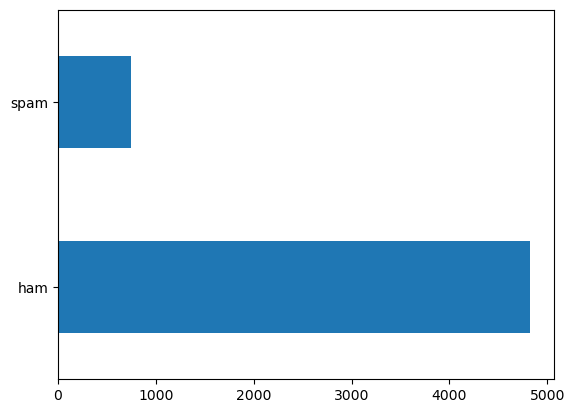

In [6]:
dataset.Category.value_counts().plot.barh()

In [7]:
#Renaming Columns
dataset.columns = ['label','text']
#mapping Category to Integer labels
category_map={'spam': 1, 'ham': 0}
dataset['label']= dataset['label'].map(category_map)

In [8]:
def sms_tokenise(text):
    text=text.lower()
    text=" ".join([contractions.fix(word) for word in text.split()])
    text=re.sub(r'[^a-zA-Z0-9]', ' ', text)
    word_tokens=word_tokenize(text)
    tokens=[token for token in word_tokens if (token not in stop_words)]
    return ' '.join(tokens)

In [9]:
dataset['text']=dataset['text'].apply(sms_tokenise)

In [10]:
get_len={lambda x: len(x.split())}
len_frame=pd.DataFrame()
len_frame['len']=dataset['text'].apply(get_len)

In [11]:
len_frame.max()

len    78
dtype: int64

In [12]:
len_frame['len'].quantile(q=[0.5,0.9])

0.5     7.0
0.9    19.0
Name: len, dtype: float64

## Vocabulary

In [13]:
from collections import Counter
class Vocabulary(object):
    def __init__(self,text_list):
        self.text_list=text_list
        self.vocab_object=Counter()
        self.token2index={'<PAD>':0,'<UNK>':1}
        self.index2token={0:'<PAD>',1:'<UNK>'}

    def create_vocab(self):
        for txt in self.text_list:
            self.vocab_object.update(txt.split())
        return   

    def __len__(self):
        return len(self.token2index)

    def make_token_dicts(self):
        self.create_vocab()
        index=len(self.token2index)
        for token, freq in self.vocab_object.items():
            self.token2index[token]=index
            self.index2token[index]=token
            index=index+1
        return 

## DataSets and  Dataloaders

In [14]:
from torch.utils.data import DataLoader, Dataset

In [15]:
class TextDataset(Dataset):
    def __init__(self,pd_table,vocab_obj,max_len):
        self.pd_table=pd_table
        self.token2index=vocab_obj.token2index
        self.max_len=max_len  
          
    def __len__(self):
        return len(self.pd_table)
    def Text2Ints(self,text,token2index):         
        return [token2index[token] if token in self.token2index else token2index['<UNK>']  for token in text.split()[:self.max_len]]
    def __getitem__(self,index):
        row=self.pd_table.iloc[index]
        text,label=row['text'],row['label']
        text_int=self.Text2Ints(text,self.token2index)
        return text_int,label

In [16]:
from torch.nn.utils.rnn import pad_sequence

class  PadCollate():
    def __init__(self,pad_token):
        self.pad=pad_token

    def __call__(self,batch):
        target_list=[]
        text_int_list=[]
        for int_list,label in batch:        
            text_int_list.append(torch.LongTensor(int_list))
            target_list.append(label)
        text_seq=pad_sequence(text_int_list,batch_first=True,padding_value=self.pad)
        seq_mask=text_seq.masked_fill(text_seq!=0,1)      
        target_list=torch.LongTensor(target_list)
        return text_seq,seq_mask,target_list

## Transformer Encoder

In [17]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
seed=0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [19]:
def positional_encodings(positions,d_model,n=10000.0):
    encodings=torch.zeros(positions,d_model)
    divisor=[ math.pow(n,(2*i/d_model)) for i in range(d_model) ]
    def get_code(pos,divisor):
        arr=[math.cos(pos/divisor[i//2]) if i%2 else math.sin(pos/divisor[i//2]) for i in range(d_model) ]
        return torch.FloatTensor(arr)
    for pos in range(positions):
        encodings[pos]=get_code(pos,divisor)
    return encodings

In [20]:
def self_attention_values(queries,keys,values,position_mask,head_size):    
    #Expected input shape: batch_size,positions,heads,head_size

    queries=torch.permute(queries,(0,2,1,3))
    keys=torch.permute(keys,(0,2,3,1))
    values=torch.permute(values,(0,2,1,3))     

    #Calculate the attentionweights and final values
    dotp=torch.matmul(queries,keys) #<Batch_Size*Heads*Positions*HeadSize>  X <Batch_Size*Heads*HeadSize*Positions> -> #<Batch_Size*Heads*Positions*Positions>
    if(position_mask is not None):
        dotp=dotp.masked_fill(position_mask==0,float("-1e30"))  #Encoder : Mask has 0 at positions where there is pad (#Decoder mask has 0 at future positions)     
    dotp=dotp/math.sqrt(head_size)
    attn_weights=F.softmax(dotp,dim=-1)  #<Batch_Size*Heads*Positions*Positions>
    attention_values=torch.matmul(attn_weights,values)#<Batch_Size*Heads*Positions*Positions> X <Batch_Size*Heads*Positions*HeadSize> -> <Batch_Size*Heads*Positions*HeadSize>

    return attention_values  

In [21]:
class Attention_SubBlock(nn.Module):
    def __init__(self,model_size,heads,head_size):
        super(Attention_SubBlock, self).__init__()
        self.model_size=model_size
        self.heads=heads
        self.head_size=self.model_size//self.heads
        self.query=nn.Linear(self.model_size,self.model_size)
        self.key=nn.Linear(self.model_size,self.model_size)
        self.value=nn.Linear(self.model_size,self.model_size)
        self.final_op=nn.Linear(self.model_size,self.model_size)


    def forward(self,input_embedding,position_mask):
        batch_size,positions,embedding_size=input_embedding.shape
        queries=self.query(input_embedding).reshape(batch_size,positions,self.heads,self.head_size)
        keys=self.key(input_embedding).reshape(batch_size,positions,self.heads,self.head_size)
        values=self.value(input_embedding).reshape(batch_size,positions,self.heads,self.head_size)
        
        attention_values=self_attention_values(queries,keys,values,position_mask,self.head_size)
        #Concat head values and combine
        attention_values=attention_values.permute(0,2,1,3).reshape(batch_size,positions,self.heads*self.head_size) #Concat Head Values
        output_value=self.final_op(attention_values) #last Linear transformation
        return output_value
           
     

In [22]:
class FeedForward_SubBlock(nn.Module):
    def __init__(self,size1,size2):
        super(FeedForward_SubBlock,self).__init__()
        self.fc1=nn.Linear(size1,size2)
        self.fc2=nn.Linear(size2,size1)
      
    def forward(self,input):      
        x=F.leaky_relu(self.fc1(input))
        x=self.fc2(x)
        return x      

In [23]:
class Transformer_Encoder_SubBlock(nn.Module):
    def __init__(self,model_size,head,head_size,dropout_prob1=0.1,dropout_prob2=0.1):
        super(Transformer_Encoder_SubBlock,self).__init__()
        self.attention_block=Attention_SubBlock(model_size,head,head_size)
        self.ff_block=FeedForward_SubBlock(model_size,model_size*4)
        self.layernorm1=nn.LayerNorm(model_size)
        self.dropout1=nn.Dropout(dropout_prob1)
        self.layernorm2=nn.LayerNorm(model_size)
        self.dropout2=nn.Dropout(dropout_prob2)

    def forward(self,input,position_mask):        
        op=self.attention_block(input,position_mask)
        op=self.layernorm1(input+self.dropout1(op))
        op=self.ff_block(op)
        op=self.layernorm2(op+self.dropout2(op))
        return op 

In [24]:
class EncoderBlock(nn.Module):
    def __init__(self,embed_size,vocab_size,max_positions,heads,layers,device,dropout_prob=0.1):
        super(EncoderBlock, self).__init__()
        self.model_size=embed_size
        self.heads=heads 
        self.head_size=self.model_size//heads    
        self.embedding_layer=nn.Embedding(vocab_size,embed_size)
        self.positional_encoding=positional_encodings(max_positions,embed_size,n=10000.0)     
        self.transformer_blocks=nn.ModuleList([copy.deepcopy(Transformer_Encoder_SubBlock(self.model_size,self.heads,self.head_size,)) for i in range(layers)])
        self.dropout=nn.Dropout(dropout_prob)
        self.device=device
     
    def forward(self,token_ints,mask):
        embeddings=self.embedding_layer(token_ints)      
        positional_encodings=self.positional_encoding[:token_ints.shape[1]].to(self.device)
        x=self.dropout(embeddings+positional_encodings)      
        encoder_mask=mask.unsqueeze(1).unsqueeze(2) #B.S,Heads,Positions,Positions
        for tb in self.transformer_blocks:
            x=tb(x,encoder_mask)
        return x

In [25]:
class SMSClassifier_Module(nn.Module):
    def __init__(self,model_size,vocab_size,max_positions,heads,layers,classes,cls_pos,device,dropout_prob=0.1):
        super(SMSClassifier_Module,self).__init__()
        self.encoder=EncoderBlock(model_size,vocab_size,max_positions,heads,layers,device)
        self.dropout=nn.Dropout(dropout_prob)
        self.fc1=nn.Linear(model_size,model_size*2)
        self.fc2=nn.Linear(model_size*2,classes)
        self.cls_pos=cls_pos
        self.device=device
    def forward(self,x,mask):     
        x=self.encoder(x,mask)[:,self.cls_pos,:]     
        x=self.dropout(x)     
        x=F.leaky_relu(self.fc1(x))
        x=self.fc2(x)
        return x

## Training and Testing

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
train_data,test_data=train_test_split(dataset,train_size=0.75,test_size=0.25,stratify=dataset[['label']])
print(f'Train data length: {len(train_data)} \nTest data Length {len(test_data)}')

Train data length: 4179 
Test data Length 1393


In [28]:
if torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")
    
print(device)

cuda


In [29]:
#Creating vocab from train data
text_list=list(train_data['text'])
vocab_obj=Vocabulary(text_list)
vocab_obj.make_token_dicts()

In [30]:
!mkdir /kaggle/working/modelop/

In [31]:
model_params={
                'model_size':512,
                'vocab_size':len(vocab_obj),
                'max_positions':100,
                'heads':8,
                'layers':2,
                'classes':2,
                'cls_pos':0,
                'device':device,
                'dropout_prob':0.1                 
             }

training_params={'epochs':10,
                 'batch_size':32, 
                 'loss_delta':0.1,
                 'check_limit':3,
                 'filename':"/kaggle/working/modelop/classifier.tar"  
                 }

training_output={
                'train_loss':[],
                 'test_loss':[],
                 'train_accuracy':[],
                 'test_accuracy':[]
                 }

In [32]:
#Train : Vocab,dataset,Loader
train_dataset=TextDataset(train_data,vocab_obj,max_len=model_params['max_positions'])
train_collate=PadCollate(vocab_obj.token2index['<PAD>'])
train_loader = DataLoader(dataset=train_dataset,batch_size=training_params['batch_size'],num_workers=2,shuffle=True,collate_fn=train_collate)

In [33]:
#Test : Vocab,dataset,Loader
test_dataset=TextDataset(test_data,vocab_obj,max_len=model_params['max_positions'])
test_collate=PadCollate(vocab_obj.token2index['<PAD>'])
test_loader = DataLoader(dataset=test_dataset,batch_size=training_params['batch_size'],num_workers=2,shuffle=True,collate_fn=test_collate)

In [34]:
def getSMSModel(model_params,device):
    model=SMSClassifier_Module(**model_params).to(device)
    for param in model.parameters():
        if(len(param.shape)>=2):
            nn.init.xavier_uniform_(param, gain=nn.init.calculate_gain('leaky_relu'))
    return model

In [35]:
model=getSMSModel(model_params,device)
print(model)

SMSClassifier_Module(
  (encoder): EncoderBlock(
    (embedding_layer): Embedding(7308, 512)
    (transformer_blocks): ModuleList(
      (0): Transformer_Encoder_SubBlock(
        (attention_block): Attention_SubBlock(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (key): Linear(in_features=512, out_features=512, bias=True)
          (value): Linear(in_features=512, out_features=512, bias=True)
          (final_op): Linear(in_features=512, out_features=512, bias=True)
        )
        (ff_block): FeedForward_SubBlock(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (layernorm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (layernorm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): Transformer_Encod

In [36]:
loss_function=nn.CrossEntropyLoss()
optimiser=torch.optim.Adam(model.parameters())

## Helper Functions

In [37]:
#Accuracy helper
def get_correct(model_output,target):
    _,predictions=torch.max(model_output,dim=-1)
    correct=(predictions==target).sum()
    return correct.item()

In [38]:
class CheckValidation(object):
    def __init__(self,limit,filename):    
        self.limit=limit
        self.filename=filename

    def checkpointer(self,model,optimiser):
        param_dict={"state_dict": model.state_dict(), 
                    "optimiser": optimiser.state_dict()}
        torch.save(param_dict, self.filename)
        print("Checkpointing model")
        return 

    def EarlyStopLoss(self,val_loss,limit):
        def isBetter(x,y,eps=0.0001):
            return x<=y-eps
        last_val=val_loss[-1]
        check_vals=val_loss[-(limit):-1]
        if(any([isBetter(last_val,l) for l in check_vals])):
            return False
        return True

    def EarlyStopAccuracy(self,acc_list,limit):
        def isBetter(x,y,eps=0.005):
            return x>=y+eps
        last_val=acc_list[-1]
        check_vals=acc_list[-(limit):-1]
        if(any([isBetter(last_val,l) for l in check_vals])):
            return False
        return True
 
    def __call__(self,acc_list,model,optimiser):
        if(len(acc_list)<3):
            return True
        if(self.EarlyStopAccuracy(acc_list,self.limit)):
            self.checkpointer(model,optimiser)
            return False
        return True 
    
'''
   def __call__(self,val_loss,model,optimiser):
    if(len(val_loss)<3):
       return True
    if(self.EarlyStop(val_loss,self.limit)):
        self.checkpointer(model,optimiser)
        return False
    return True 
'''  

'\n   def __call__(self,val_loss,model,optimiser):\n    if(len(val_loss)<3):\n       return True\n    if(self.EarlyStop(val_loss,self.limit)):\n        self.checkpointer(model,optimiser)\n        return False\n    return True \n'

In [39]:
check_validation=CheckValidation(training_params["check_limit"],training_params["filename"])

## Training Loop

In [40]:
from tqdm import tqdm

In [41]:
torch.autograd.set_detect_anomaly(True)

In [42]:
train_batches=len(train_dataset)//training_params['batch_size']  
test_batches=len(test_dataset)//training_params['batch_size'] 
print(train_batches,test_batches)

130 43


In [43]:
def train_module(training_params,training_output,model,loss_function,optimiser,train_loader,test_loader,check_validation):
    
    print("Starting Training")
    for index in range(training_params['epochs']):  #EPOCH   
        model.train()
        epoch_train_loss=0
        total_train_size=0   
        train_accuracy=0
        
        tq_train=tqdm(train_loader,desc='Training')
        tq_test=tqdm(test_loader,desc='Testing')
        
        for batch_id,(input,mask,target) in enumerate(tq_train):
            optimiser.zero_grad()
            
            input=input.to(device)
            mask=mask.to(device)
            target=target.to(device) 
            
            output=model(input,mask) 
            
            loss=loss_function(output,target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=1,error_if_nonfinite=True) 
            optimiser.step()  
            
            epoch_train_loss+=loss.item()
            train_accuracy+=get_correct(output,target)        
            total_train_size+=input.shape[0]

        training_output['train_loss'].append(float(1.0*epoch_train_loss)/train_batches)
        training_output['train_accuracy'].append((100.0*train_accuracy)/total_train_size) 
        tq_train.set_description(f"Training  [{index}/{training_params['epochs']}]  ")



        #Evaluation
        model.eval()
        epoch_test_loss=0
        total_test_size=0 
        test_accuracy=0 

        for batch_id,(input,mask,target) in enumerate(tq_test):        
            input=input.to(device)
            mask=mask.to(device)
            target=target.to(device)

            output=model(input,mask)
            
            loss=loss_function(output,target)      

            epoch_test_loss+=loss.item()
            total_test_size+=input.shape[0]
            test_accuracy+=get_correct(output,target)       

        training_output['test_loss'].append(float(1.0*epoch_test_loss)/test_batches) 
        training_output['test_accuracy'].append((100.0*test_accuracy)/total_test_size)
        tq_test.set_description(f"Testing [{index}/{training_params['epochs']}] ")
        
        if((index%3==0) and  (not check_validation(training_output['test_accuracy'],model,optimiser))):
            print("Accuracy not improving stopping early")
            return  training_output
        
    print("Finished Training")
    check_validation.checkpointer()
    return training_output
    

In [44]:
import matplotlib.pyplot as plt

def plot_output(training_output):
    
    figure, axis = plt.subplots(2, 2)
    plt.rcParams["lines.linestyle"] = '--'
    x1=training_output['train_loss']
    x2=training_output['test_loss']
    x3=training_output['train_accuracy']
    x4=training_output['test_accuracy']


    axis[0, 0].plot(x1)
    axis[0, 0].set_title("Train Loss ")

    axis[0, 1].plot(x2)
    axis[0, 1].set_title("Test Loss ")

    axis[1, 0].plot(x3)
    axis[1, 0].set_title('Train accuracy')

    axis[1, 1].plot(x4)
    axis[1, 1].set_title("Test accuracy ")
    
    return

In [45]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_curve, auc,f1_score


def get_classifier_outputs(loader,model,device):  
    probabs=[]
    preds=[]
    ground_truth=[]    
    for batch_id,(input,mask,target) in enumerate(loader):        
        input=input.to(device)
        mask=mask.to(device)
        target=target.to(device) 
        output=model(input,mask)        
        output=F.softmax(output,dim=-1)
        probabs.extend(output[:,1].tolist())
        _,predictions=torch.max(output,dim=-1)
        preds.extend(predictions.tolist())
        ground_truth.extend(target.tolist())
    return probabs,preds,ground_truth

def value_metrics(ground_truth,predictions,data_type):
    print(data_type+": \n")
    print("=========================== \n")
    print(f"Accuracy: {accuracy_score(ground_truth, predictions)}")
    print(f"Precision: {precision_score(ground_truth, predictions)}")
    print(f"Recall: {recall_score(ground_truth, predictions)}")
    print(f"F1 Score: {f1_score(ground_truth, predictions)}")
    return

def cmatrix(ground_truth, predictions):
    c_mat = confusion_matrix(ground_truth, predictions) 
    display = ConfusionMatrixDisplay(confusion_matrix=c_mat)
    display.plot()
    plt.show()
    
    return 

def get_classification_metrics(train_loader,test_loader,model,device):
    model.eval()
    train_probabs,train_preds,train_gt=get_classifier_outputs(train_loader,model,device)
    train_probabs,train_preds,train_gt=np.array(train_probabs),np.array(train_preds),np.array(train_gt)
    test_probabs,test_preds,test_gt=get_classifier_outputs(test_loader,model,device)
    test_probabs,test_preds,test_gt=np.array(test_probabs),np.array(test_preds),np.array(test_gt)
    
    value_metrics(train_gt,train_preds,"Metrics on Train Data ")
    cmatrix(train_gt, train_preds)
    
    value_metrics(test_gt,test_preds,"Metrics on Test Data ")
    cmatrix(test_gt, test_preds)
    return
    

In [46]:
training_output=train_module(training_params,training_output,model,loss_function,optimiser,train_loader,test_loader,check_validation)

Starting Training


Training: 100%|██████████| 131/131 [00:14<00:00,  8.87it/s]

Training: 100%|██████████| 131/131 [00:11<00:00, 11.41it/s]

Training: 100%|██████████| 131/131 [00:11<00:00, 11.51it/s]

Training: 100%|██████████| 131/131 [00:11<00:00, 11.63it/s]

Training: 100%|██████████| 131/131 [00:11<00:00, 11.16it/s]

Training: 100%|██████████| 131/131 [00:11<00:00, 11.52it/s]

Training: 100%|██████████| 131/131 [00:11<00:00, 11.16it/s]

Training: 100%|██████████| 131/131 [00:11<00:00, 11.64it/s]

Training: 100%|██████████| 131/131 [00:11<00:00, 11.15it/s]

Training: 100%|██████████| 131/131 [00:11<00:00, 11.63it/s]

Testing: 100%|██████████| 44/44 [00:13<00:00,  3.19it/s]


Checkpointing model
Accuracy not improving stopping early


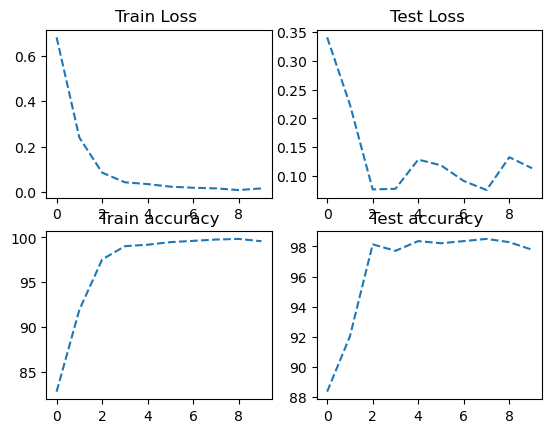

In [47]:
plot_output(training_output)

Metrics on Train Data : 


Accuracy: 0.9973677913376405
Precision: 1.0
Recall: 0.9803571428571428
F1 Score: 0.9900811541929667


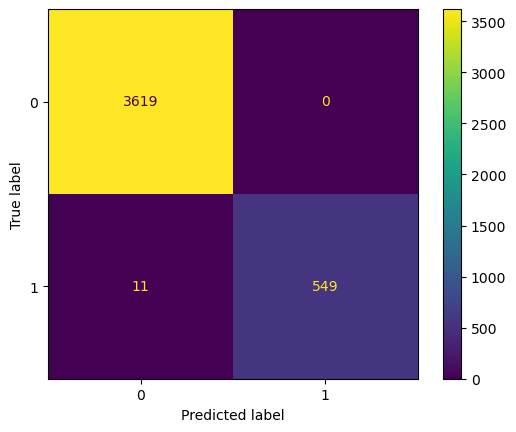

Metrics on Test Data : 


Accuracy: 0.9777458722182341
Precision: 0.9875
Recall: 0.8449197860962567
F1 Score: 0.9106628242074929


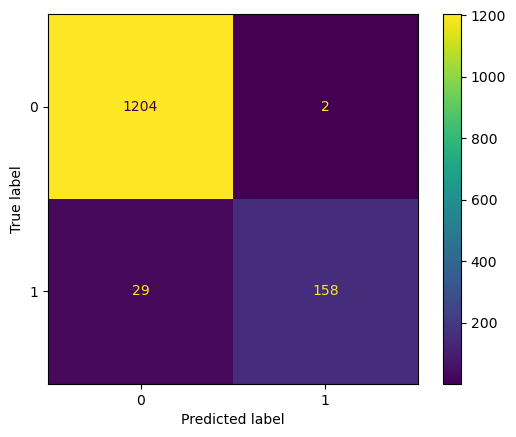

In [48]:
get_classification_metrics(train_loader,test_loader,model,device)

## Adding Few Helpful Resources for Guidance:
1. [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)
2. [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)